In [1]:
import pandas as pd
import numpy as np

csv_file_path = 'fake_transactional_data_24.csv'
df = pd.read_csv(csv_file_path)

def count_daily(shop):
    data = df[df['to_randomly_generated_account'] == shop]

    #按天汇总
    data['not_happened_yet_date'] = pd.to_datetime(data['not_happened_yet_date'], format='%d/%m/%Y')

    # 设置日期列为索引
    data.set_index('not_happened_yet_date', inplace=True)

    # 按天汇总交易额并输出
    data_daily = data['monopoly_money_amount'].resample('D').sum().reset_index()
    data_daily.to_csv(f'{shop}_daily_transactions.csv', index=False)

In [8]:
# 加载数据
count_daily('LARGE_SUPERMARKET')
path = 'LARGE_SUPERMARKETdaily_transactions.csv'
data = pd.read_csv(path)
data['not_happened_yet_date'] = pd.to_datetime(data['not_happened_yet_date'], format='%Y-%m-%d')
data.set_index('not_happened_yet_date', inplace=True)

C:\Users\12147\AppData\Local\Temp\ipykernel_18248\3160433762.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['not_happened_yet_date'] = pd.to_datetime(data['not_happened_yet_date'], format='%d/%m/%Y')


In [3]:
# data = pd.read_csv('a_cafe_daily_transactions.csv')
# data['not_happened_yet_date'] = pd.to_datetime(data['not_happened_yet_date'])

# # Splitting the dataset into training and testing sets
# train_data = data[data['not_happened_yet_date'].dt.month <= 9]
# test_data = data[(data['not_happened_yet_date'].dt.month >= 10) & (data['not_happened_yet_date'].dt.month <= 11)]

# train_data.to_csv('a_cafe_transactions_train.csv', index=False)
# test_data.to_csv('a_cafe_transactions_test.csv', index=False)

In [4]:
# import matplotlib.pyplot as plt
# from statsmodels.tsa.stattools import adfuller

# train_data = pd.read_csv('a_cafe_transactions_train.csv')
# test_data = pd.read_csv('a_cafe_transactions_test.csv')
# # Convert the date column to datetime
# train_data['not_happened_yet_date'] = pd.to_datetime(train_data['not_happened_yet_date'])
# test_data['not_happened_yet_date'] = pd.to_datetime(train_data['not_happened_yet_date'])

# # Set the date as the index
# train_data.set_index('not_happened_yet_date', inplace=True)
# test_data.set_index('not_happened_yet_date', inplace=True)

In [9]:
#Data pre-processing
# Find the zero value and replace it with the average of the day before and the day after
zero_value_date = data.index[data['monopoly_money_amount'] == 0]
if not zero_value_date.empty:
    for zero_date in zero_value_date:
        day_before = zero_date - pd.Timedelta(days=1)
        day_after = zero_date + pd.Timedelta(days=1)
        average_income = data.loc[[day_before, day_after], 'monopoly_money_amount'].mean()
        data.loc[zero_date, 'monopoly_money_amount'] = average_income

# Confirm the changes
data.head()


,monopoly_money_amount
not_happened_yet_date,
2025-01-01,9090.37
2025-01-02,8804.71
2025-01-03,12463.90
2025-01-04,11916.73
2025-01-05,12107.76


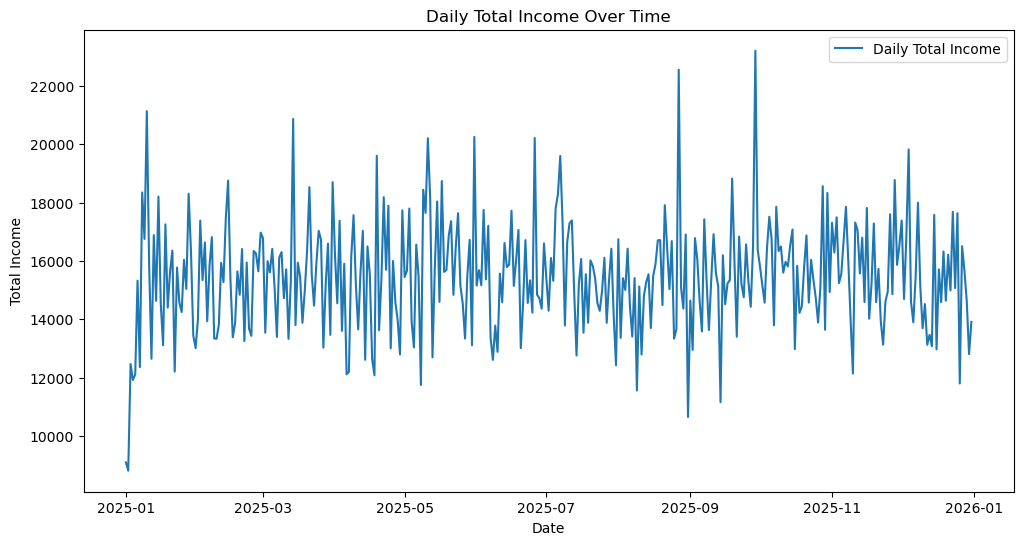

In [11]:
# Plot the daily total income
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['monopoly_money_amount'], label='Daily Total Income')
plt.title('Daily Total Income Over Time')
plt.xlabel('Date')
plt.ylabel('Total Income')
plt.legend()
plt.show()

In [12]:
#ADF test
# Perform Augmented Dickey-Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(data['monopoly_money_amount'])

adf_result

(-18.87188145690076,
 0.0,
 0,
 364,
 {'1%': -3.4484434475193777,
  '5%': -2.869513170510808,
  '10%': -2.571017574266393},
 6186.458400152025)

     lb_stat  lb_pvalue
10  3.733125   0.958584


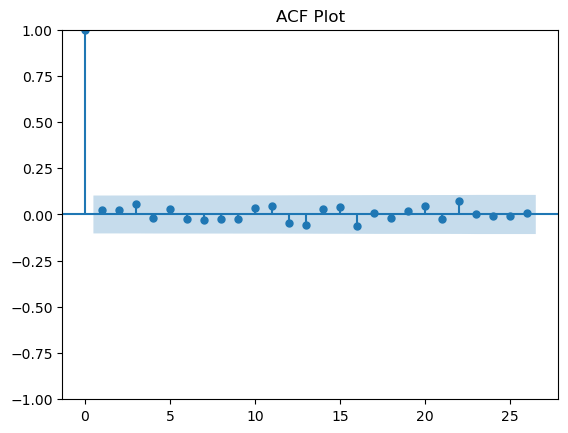

In [13]:
#Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(data, lags=[10], return_df=False)
print(lb_result)

# ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data)
plt.title('ACF Plot')
plt.show()

是白噪声

平稳性检验小于5%

In [ ]:
# Performing first-order differencing on the data
train_data_diff = train_data.diff().dropna()

#ADF test
# Perform Augmented Dickey-Fuller test to check for stationarity
adf_result = adfuller(train_data_diff['monopoly_money_amount'])

adf_result


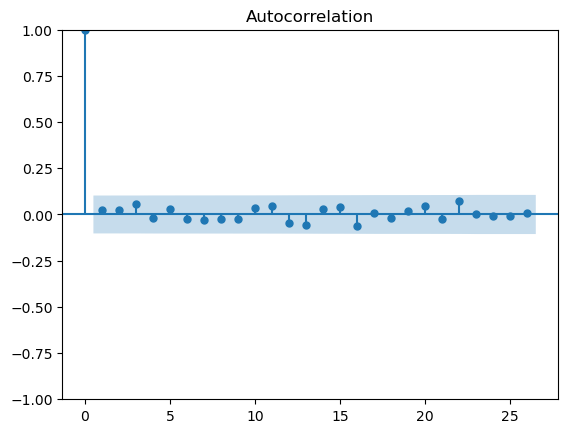

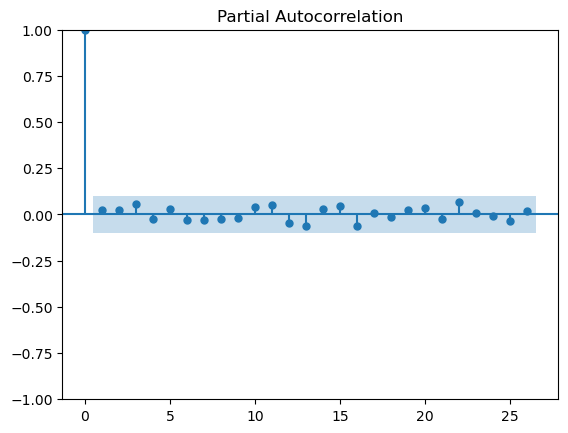

In [14]:
# 绘制ACF和PACF图
plot_acf(data)
plt.show()

plot_pacf(data)
plt.show()

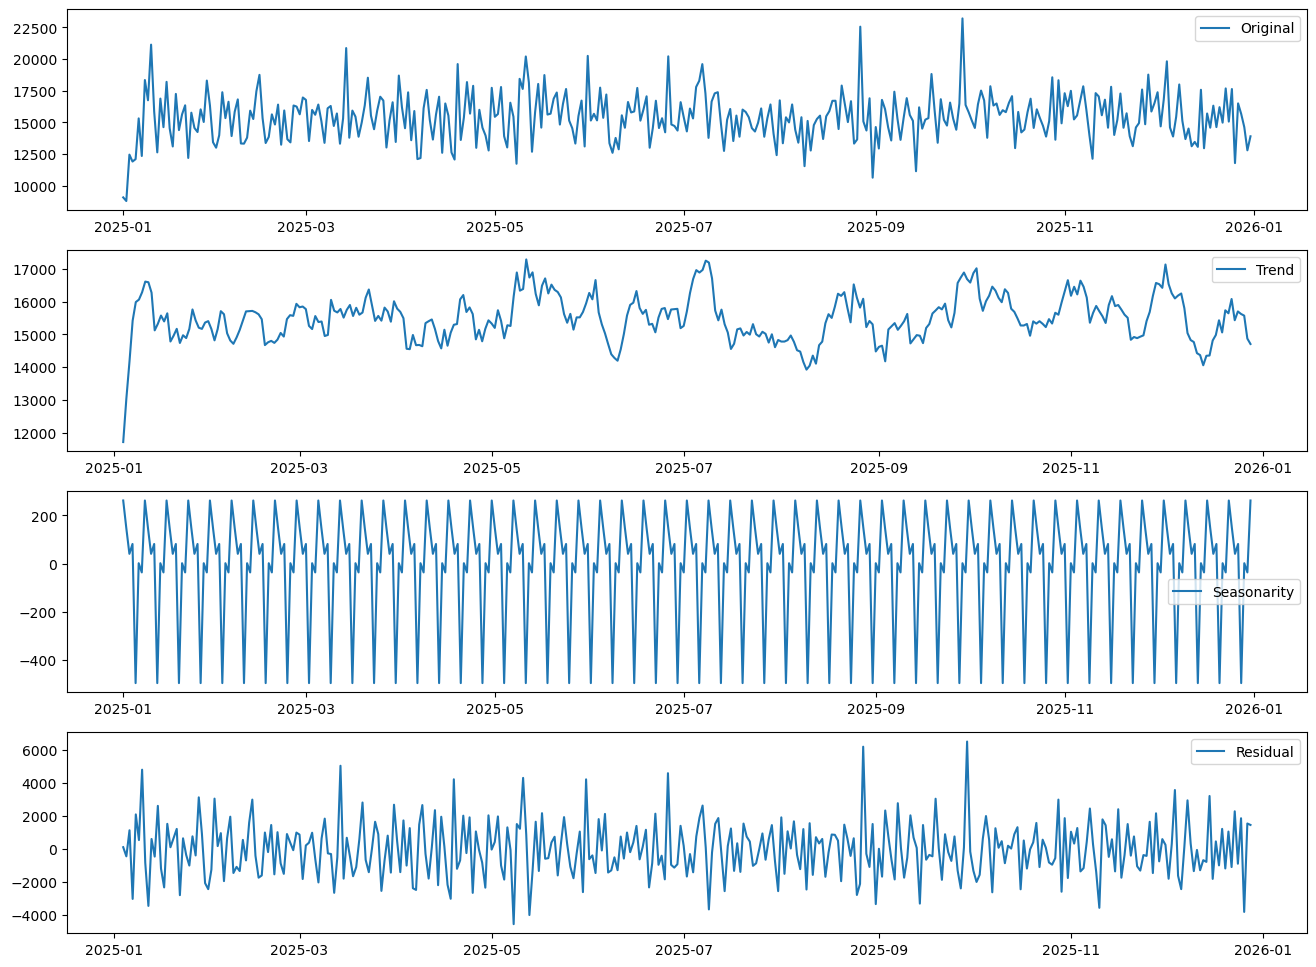

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF


def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16, 12))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.show()


# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# purchase_seq_train = pd.read_csv('./purchase_seq_train.csv', parse_dates=['report_date'],
#                                  index_col='report_date', date_parser=dateparse)

decomposing(data)

从第三幅图能看出序列具有严格的季节性，使用SARIMA模型

先不用SARIMA，而是手动对季节差分，之后使用ARIMA

In [20]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

def find_pq_PQ(ts, m, d, D, max_p=5, max_q=5, max_P=2, max_Q=2):
    best_p, best_q = 0, 0
    best_P, best_Q = 0, 0
    best_aic = np.inf

    for p in range(max_p):
        for q in range(max_q):
            for P in range(max_P):
                for Q in range(max_Q):
                    model = SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit(disp=-1)
                    aic = model.aic

                    if aic < best_aic:
                        best_aic = aic
                        best_p = p
                        best_q = q
                        best_P = P
                        best_Q = Q

    return best_p, best_q, best_P, best_Q, best_aic

def version_sarima_with_manual(ts):
    """
    SARIMA（statsmodels）
    """
    # 不提前做季节差分，让D=1

    # 周期大小
    periods = 7

    # 数据拆分
    train, test = train_test_split(ts, train_size=0.8)

    # 模型训练
    d, D = 0, 1
    p, q, P, Q, _ = find_pq_PQ(ts, periods, d=d, D=D)
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, periods)).fit(disp=-1)
    print(model.summary())

    # 拟合结果
    fitted = model.fittedvalues

    # 模型预测
    fcst = model.forecast(test.shape[0])

    # 模型评估
    rmse = np.sqrt(mean_squared_error(test, fcst))
    print('RMSE: %.4f' % rmse)

    # 可视化
    plt.figure(figsize=(12, 4))
    ts.plot(label='Ads')
    fitted.plot(label='fitted')
    fcst.plot(label='forecast')
    plt.legend()
    plt.grid(True)
    plt.title('SARIMA')
    # 导出图形到文件，例如保存为PNG格式
    plt.savefig('a_cafe_result.png')
    plt.show()
    
version_sarima_with_manual(data)

D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\

D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\

D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\app\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

D:\app\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

LinAlgError: LU decomposition error.

D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\app\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:             monopoly_money_amount   No. Observations:                  292
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2635.534
Date:                           Wed, 06 Mar 2024   AIC                           5277.068
Time:                                   23:00:36   BIC                           5288.026
Sample:                               01-01-2025   HQIC                          5281.461
                                    - 10-19-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2646      0.051      5.212      0.000       0.165       0.364
ma.S.L7       -0.6034      0.054    -11.177

<Figure size 1200x400 with 0 Axes>

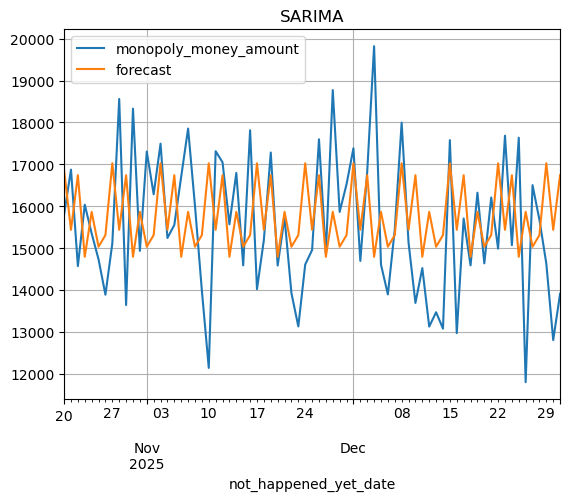

In [18]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
def version_sarima(ts):
    """
    SARIMA（statsmodels）
    """
    # 不提前做季节差分，让D=1

    # 周期大小
    periods = 7

    # 数据拆分
    train, test = train_test_split(ts, train_size=0.8)

    # 模型训练
    d, D = 0, 1
    p, q, P, Q= 0,1,0,1
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, periods)).fit(disp=-1)
    print(model.summary())

    # 拟合结果
    fitted = model.fittedvalues

    # 模型预测
    fcst = model.forecast(test.shape[0])

    # 模型评估
    rmse = np.sqrt(mean_squared_error(test, fcst))
    print('RMSE: %.4f' % rmse)

    # 可视化
    plt.figure(figsize=(12, 4))
    test.plot(label='Ads')
#     fitted.plot(label='fitted')
    fcst.plot(label='forecast')
    plt.legend()
    plt.grid(True)
    plt.title('SARIMA')
    # 导出图形到文件，例如保存为PNG格式
    plt.savefig('a_cafe_result.png')
    plt.show()
    
version_sarima(data)